# Convolutional Neural Networks with Pytorch
# Detection of Defects on Metallic Surfaces

## Possible Business Use Cases

This neural network can be applied to the **iron and steel industry** or **machine manufacturers** as it can help to identify defects on the surface of a metal part produced by a casting process.  

An inspection system should be set up and collect the **binary images** using vision technology. Connected components of these images are processed to **find the shadows** originated from defects. Then convert these images into pixels before passing into the **neural network** which will be processing on **GPUs** to accelerate the computation speed.


### Import the libraries and set the random seed

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm # for showing the progess bar
from torchvision import datasets, transforms, models
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
manualSeed = 999

np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

## Detection Process

### Step 1 : Import the data(images)


In [3]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in the training data

class DefectClass():
    IMG_SIZE = 200 # image size is 200x200
    
    # Directory of the images
    crazing = 'Database/Crazing'
    inclusions = 'Database/Inclusions'
    patches = 'Database/Patches'
    pittedSurface = 'Database/PittedSurface'
    rolledInScale = 'Database/RolledInScale'
    scratches = 'Database/Scratches'
    
    # Assign a label to each class
    LABELS = {crazing : 0 , inclusions : 1 , patches : 2, pittedSurface : 3, rolledInScale : 4, scratches : 5}
    training_data = [] # Create a list of the training data
    
    # For counting the number of images of each class
    crazingcount = 0
    inclusionscount = 0
    patchescount = 0
    pittedSurfacecount = 0
    rolledInScalecount = 0
    scratchescount = 0
    
    

    # Import the images to the corresponding category
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)): # Iterating through the directories
                if "bmp" in f :
                    try:
                        path = os.path.join(label, f) # The path consist of directory and the file of image(bmp)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Convert to grayscale
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)) # Resize the image to 200x200
                        self.training_data.append([np.array(img), np.eye(6)[self.LABELS[label]]])  # Add the image along with the associated class in number form to our training_data
                        # np.eye(6)[self.LABELS[label]]] makes the label one-hot encoded across 6 classes
                        
                        
                        # Count the number of images of each class
                        if label == self.crazing:
                            self.crazingcount += 1
                        elif label == self.inclusions:
                            self.inclusionscount += 1
                        elif label == self.patches:
                            self.patchescount += 1
                        elif label == self.pittedSurface:
                            self.pittedSurfacecount += 1
                        elif label == self.rolledInScale:
                            self.rolledInScalecount += 1
                        elif label == self.scratches:
                            self.scratchescount += 1

                    except Exception as e: # In case not an image file, pass it
                        pass
                        print(label, f, str(e))
                        
        np.random.seed(999) # Set the random seed 
        np.random.shuffle(self.training_data) # Shuffle the training data
        np.save("training_data.npy", self.training_data) # Save the training data as a .npy file
        
        print('crazing:',self.crazingcount)
        print('inclusions:',self.inclusionscount)
        print('patches:',self.patchescount)
        print('pittedSurface:',self.pittedSurfacecount)
        print('rolledInScale:',self.rolledInScalecount)
        print('scratches:',self.scratchescount)

# If the switch (rebuild_data) is on, the data set(.npy) will be overwritten        
if REBUILD_DATA:
    defect = DefectClass()
    defect.make_training_data()


 42%|████▏     | 125/300 [00:00<00:00, 1239.03it/s]

Database/Crazing


 36%|███▌      | 107/300 [00:00<00:00, 1060.57it/s]

Database/Inclusions


 33%|███▎      | 99/300 [00:00<00:00, 986.89it/s]

Database/Patches


 55%|█████▌    | 166/300 [00:00<00:00, 1649.54it/s]

Database/PittedSurface


 36%|███▌      | 108/300 [00:00<00:00, 1071.58it/s]

Database/RolledInScale


 43%|████▎     | 130/300 [00:00<00:00, 1290.41it/s]

Database/Scratches


100%|██████████| 300/300 [00:00<00:00, 1224.00it/s]


crazing: 300
inclusions: 300
patches: 300
pittedSurface: 300
rolledInScale: 300
scratches: 300


We have a balanced data set as there are 300 images for every class.


#### Load the data from the .npy saved previously and check the number of data points in the whole data set.

In [4]:

training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

1800


### Step 2 : Split the Data Set into X and y
### And convert it to a tensor

In [5]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,200,200) # (-1, IMG_SIZE, IMG_SIZE)
X = X/255.0 # Normalize the pixel of the images (i.e. between 0 and 1)
y = torch.Tensor([i[1] for i in training_data])

#### Check if X and y are correctly seperated

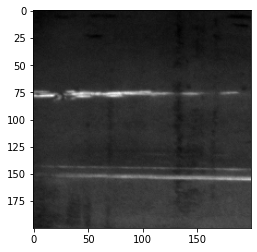

In [6]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap="gray")

In [7]:
# LABELS = {crazing : 0 , inclusions : 1 , patches : 2, pittedSurface : 3, 
# rolledInScale : 4, scratches : 5}

print(y[0])

tensor([0., 0., 0., 0., 0., 1.])


This picture is a metal surface with scratches as it is under class 5.

### Step 3 : Train-Test Split

In [8]:
VAL_PCT = 0.3 # Reserve 30% of data for validation
val_size = int(len(X)*VAL_PCT)
print(f'The number of test images : {val_size}')

The number of test images : 540


In [9]:
torch.manual_seed(999)

# Training set (first 1260 images)
train_X = X[:-val_size]
train_y = y[:-val_size]

# Testing set ( last 540 imaages)
test_X = X[-val_size:]
test_y = y[-val_size:]

### Step 4 : Build a Convolutional Neural Network

A convolutional neural network aims to use a **sliding window (a kernel)** that takes into account a group of pixels, to recognize small features like "edges" or "curves" and then another layer might take combinations of edges or curves to detect shapes like squares or circles in order to find the pattern or features of the images.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # Run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32(first layer output), output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5) # input is 64(second layer output), 128 output channels, 5x5 kernel / window

        # Determine the actual shape of the flattened output after the first convolutional layers  
        x = torch.randn(200,200).view(-1,1,200,200) # Pass some random data to generate the flatten output
        self._to_linear = None # Set the flatten output as NA
        self.convs(x) # Apply the conversion function (below)
        
        # Add the dense/linear layer to the network
        self.fc1 = nn.Linear(self._to_linear, 512) # From the flatten output of the last convolutional layer as input
        self.fc2 = nn.Linear(512, 256) # 512 input ( the output of the first dense/linear layer)
        self.fc3 = nn.Linear(256, 6) # 6 outputs ( 6 classes)

      
    def convs(self, x):
        # Apply rectified linear on each convolutional layers (F.relu)
        # With max pooling over 3x3
        # Simply take the maximum value in the window, and that becomes the new value for that region.
        x = F.max_pool2d(F.relu(self.conv1(x)), (3, 3))
        x = F.max_pool2d(F.relu(self.conv2(x)), (3, 3))
        x = F.max_pool2d(F.relu(self.conv3(x)), (3, 3))

        if self._to_linear is None: # Calculate the flatten output of the convolutional layer 
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] # Flatten output = the dimensions of the tensor(x,y,z) : x*y*z
        return x # Continue to be passed through more layers

    def forward(self, x):
        x = self.convs(x) # Get the calculated output of the convolutional layer
        x = x.view(-1, self._to_linear)  # Flatten the output of the convolutional layer(.view is reshape)
        x = F.relu(self.fc1(x)) # Apply the rectified linear unit function on the first fully connected layer
        x = F.relu(self.fc2(x)) # Apply the rectified linear unit function on the second fully connected layer
        x = self.fc3(x) # Output layer. No activation needed.
        return F.softmax(x, dim=1) # Softmax layer determines the likelihood of that one item being to a class


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)


### Loss Metric and Optimizer

In [11]:
import torch.optim as optim

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001) # The learning rate dictates the magnitude of changes that the optimizer can make at a time
loss_function = nn.MSELoss() # Use mean squared error as the loss function because we are using one-hot vectors

### Step 5 : Train the Neural Network

In [12]:
BATCH_SIZE = 10
EPOCHS = 30

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # From 0, to the len of x, stepping BATCH_SIZE at a time
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 200, 200) # Put the training set into batches 
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad() # Set gradients to 0 before loss calculation, otherwise these gradients will add up for every pass
        
        optimizer.zero_grad()   # Zero the gradient buffers
        outputs = net(batch_X) # Pass in the reshaped batch
        loss = loss_function(outputs, batch_y) # Calculate and grab the loss value
        loss.backward() # Apply this loss backwards thru the network's parameters
        optimizer.step()  # Attempt to optimize weights to account for loss/gradients

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/126 [00:00<?, ?it/s]C:\Users\suki9\Anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.11637984961271286


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.07807033509016037


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.07199151813983917


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.04651413485407829


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.01247488334774971


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.032378390431404114


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.027361268177628517


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.023606138303875923


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.023693514987826347


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 9. Loss: 0.07659458369016647


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 10. Loss: 0.02748042345046997


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.029116252437233925


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 12. Loss: 0.0296418946236372


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 13. Loss: 0.021507274359464645


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 14. Loss: 0.022439980879426003


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 15. Loss: 0.02705010399222374


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 16. Loss: 0.0209891926497221


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 17. Loss: 0.02176443673670292


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 18. Loss: 0.023371612653136253


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 19. Loss: 0.024188004434108734


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 20. Loss: 0.019253678619861603


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 21. Loss: 0.02330251969397068


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 22. Loss: 0.015704309567809105


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 23. Loss: 0.02070016972720623


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 24. Loss: 0.02002200484275818


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 25. Loss: 0.026294177398085594


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 26. Loss: 0.015984218567609787


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 27. Loss: 0.015619063749909401


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 28. Loss: 0.027931513264775276


100%|██████████| 126/126 [01:31<00:00,  1.38it/s]

Epoch: 29. Loss: 0.016654158011078835


## Evaluation

### Test the Accuracy of the Network

Pass the testing set into the network and check the accuracy of the predictions.

In [23]:
correct = 0
total = 0

torch.manual_seed(999)

print('Images that cannot be identified correctly :' )
with torch.no_grad():
    for i in range(len(test_X)):
        real_class = torch.argmax(test_y[i]) # Grab the actual class of the testing data
        net_out = net(test_X[i].view(-1, 1, 200, 200))[0]  # Put the testing data in the network, returns a list
        predicted_class = torch.argmax(net_out) # Grab the predicted class of the testing data

        if predicted_class == real_class:
            correct += 1
        else:
            print(i)
        total += 1

print("\nNumber Of Images Tested =", total)
print("Number Of Images Correctly Identified =", correct)    
print("\nAccuracy: ", round(correct/total, 3))

Images that cannot be identified correctly :
7
19
21
27
67
138
146
154
164
188
217
233
234
242
251
254
271
283
331
377
380
412
415
469
477
479
533

Number Of Images Tested = 540
Number Of Images Correctly Identified = 513

Accuracy:  0.95


### Test One Images



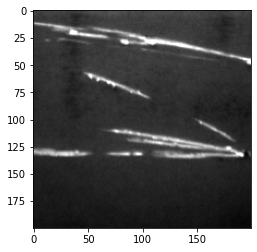

In [15]:
# The 10th Image in the teseting set
plt.imshow(test_X[10], cmap="gray")

In [16]:
# Actual class of the image
print('Actual Class of the Image : ' , test_y[10])

# Predicted class of the image
net_out_10 = net(test_X[10].view(-1, 1, 200, 200))[0]  # Put the testing data in the network, returns a list
predicted_class_10 = torch.argmax(net_out_10) 
print('Predicted Class of the Image : ' , predicted_class_10)

Actual Class of the Image :  tensor([0., 0., 0., 0., 0., 1.])
Predicted Class of the Image :  tensor(5)


Recall LABELS = {crazing : 0 , inclusions : 1 , patches : 2, pittedSurface : 3, rolledInScale : 4, scratches : 5},  
both predicted and actual class of the 10th image in the testing set is **5, scratches**.
The model predict the class correctly.

### Check the incorrect image

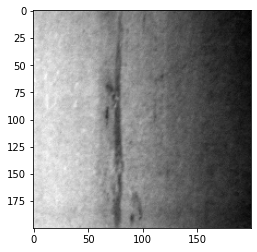

In [22]:
# The 19th Image in the teseting set
plt.imshow(test_X[19], cmap="gray")

In [20]:
# Actual class of the image
print('Actual Class of the Image : ' , test_y[19])

# Predicted class of the image
net_out_19 = net(test_X[19].view(-1, 1, 200, 200))[0]  # Put the testing data in the network, returns a list
predicted_class_19 = torch.argmax(net_out_19) 
print('Predicted Class of the Image : ' , predicted_class_19)

Actual Class of the Image :  tensor([0., 1., 0., 0., 0., 0.])
Predicted Class of the Image :  tensor(3)


This is an image of **inclusions** but the network classifies it as **pitted surface**. For pitted surface, we can see many small dots on the surface. The neural network may get confused as the image above shows many **noises(dark dots)**. But the neural network should have recognised the feature of inclusions, i.e. the black lines.